In [1]:
!pip install transformers datasets scikit-learn pandas indic-transliteration torch
!pip install indic-transliteration
!pip install --upgrade indic-transliteration
!pip install matplotlib

import os

# Disable wandb logging
os.environ['WANDB_MODE'] = 'disabled'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing i

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        
        
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        if isinstance(alpha, (float, int)):
            self.alpha = torch.tensor([alpha, 1-alpha])
        elif isinstance(alpha, list):
            self.alpha = torch.tensor(alpha)
        else:
            self.alpha = None
        self.reduction = reduction

    def forward(self, inputs, targets):
        
        # Compute cross entropy loss without reduction
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  
        
        
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            
            at = self.alpha.gather(0, targets)
            focal_loss = at * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [3]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt

from transformers import (AutoTokenizer, BertModel, BertPreTrainedModel, 
                          Trainer, TrainingArguments, BertConfig)
from datasets import Dataset, ClassLabel


mode_flag = "train"  

MODEL_NAME = "bert-base-multilingual-cased"

BEST_MODEL_DIR = "./best_multitask_model"

2025-04-15 14:46:40.189460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744728400.375397      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744728400.428125      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:

try:
    from indic_transliteration import sanscript
    from indic_transliteration.sanscript import transliterate
except ImportError:
    raise ImportError("Please install 'indic-transliteration' via 'pip install indic-transliteration'")

def convert_hinglish_to_hindi(text):
    
    def count_devanagari_ratio(text):
        
        if not text:
            return 0
        count_devanagari = sum(1 for ch in text if '\u0900' <= ch <= '\u097F')
        return count_devanagari / len(text)

    def transliterate_to_hindi(text):
        
        return transliterate(text, sanscript.ITRANS, sanscript.DEVANAGARI)

    if not text:
        return text
    return transliterate_to_hindi(text) if count_devanagari_ratio(text) < 0.3 else text


multitask_file_paths = {
    "en": {
         "train_label1": "/kaggle/input/gender-abuse-train/train_en_l1.csv",
         "train_label3": "/kaggle/input/gender-abuse-train/train_en_l3.csv",
         "test_label1": "/kaggle/input/gender-abuse-test/test_en_l1.csv",
         "test_label3": "/kaggle/input/gender-abuse-test/test_en_l3.csv",
    },
    "hi": {
         "train_label1": "/kaggle/input/gender-abuse-train/train_hi_l1.csv",
         "train_label3": "/kaggle/input/gender-abuse-train/train_hi_l3.csv",
         "test_label1": "/kaggle/input/gender-abuse-test/test_hi_l1.csv",
         "test_label3": "/kaggle/input/gender-abuse-test/test_hi_l3.csv",
    },
    "ta": {
         "train_label1": "/kaggle/input/gender-abuse-train/train_ta_l1.csv",
         "train_label3": "/kaggle/input/gender-abuse-train/train_ta_l3.csv",
         "test_label1": "/kaggle/input/gender-abuse-test/test_ta_l1.csv",
         "test_label3": "/kaggle/input/gender-abuse-test/test_ta_l3.csv",
    }
}


def aggregate_labels(df, lang):
    
    def get_expected_cols(lang):
        
        if lang == 'en':
            return [f"en_a{i}" for i in range(1, 7)]
        elif lang == 'hi':
            return [f"hi_a{i}" for i in range(1, 6)]
        elif lang == 'ta':
            return [f"ta_a{i}" for i in range(1, 7)]
        else:
            raise ValueError("Unknown language specified.")

    def compute_labels(df, annotator_cols):
        
        df[annotator_cols] = df[annotator_cols].apply(pd.to_numeric, errors='coerce')
        df['avg_annotation'] = df[annotator_cols].mean(axis=1)
        df['label'] = (df['avg_annotation'] >= 0.5).astype(int)
        return df

    expected = get_expected_cols(lang)
    annotator_cols = [col for col in expected if col in df.columns]
    if not annotator_cols:
        raise ValueError(f"No annotator columns found for language '{lang}'.")
    
    return compute_labels(df, annotator_cols)

def check_required_columns(df, required_cols):
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def augment_text(text, deletion_prob=0.1):
    
    words = text.split()
    if not words:
        return text
    new_words = [w for w in words if random.random() > deletion_prob]
    return " ".join(new_words) if new_words else text


In [5]:

def load_multitask_data(lang, train_path_label1, train_path_label3):
    
    def load_single_label(path, question_key, label_name):
        
        df = pd.read_csv(path, engine='python')
        check_required_columns(df, ['key', 'text'])
        df = df[df['key'] == question_key]
        if lang == "hi":
            df['text'] = df['text'].apply(convert_hinglish_to_hindi)
        return aggregate_labels(df, lang).rename(columns={'label': label_name})[['text', label_name]]

    def merge_labels():
        
        df1 = load_single_label(train_path_label1, "question_1", "labels1")
        df3 = load_single_label(train_path_label3, "question_3", "labels3")
        return pd.merge(df1, df3, on="text", how="inner")

    return merge_labels()

def load_multitask_test_data(lang, test_path_label1, test_path_label3):
    
    def load_single_label(path, question_key, label_name):
        
        df = pd.read_csv(path, engine='python')
        check_required_columns(df, ['key', 'text'])
        df = df[df['key'] == question_key]
        if lang == "hi":
            df['text'] = df['text'].apply(convert_hinglish_to_hindi)
        return aggregate_labels(df, lang).rename(columns={'label': label_name})[['text', label_name]]

    def merge_labels():
        
        df1 = load_single_label(test_path_label1, "question_1", "labels1")
        df3 = load_single_label(test_path_label3, "question_3", "labels3")
        return pd.merge(df1, df3, on="text", how="inner")

    return merge_labels()


df_en_mt = load_multitask_data("en", multitask_file_paths["en"]["train_label1"], multitask_file_paths["en"]["train_label3"])
df_hi_mt = load_multitask_data("hi", multitask_file_paths["hi"]["train_label1"], multitask_file_paths["hi"]["train_label3"])
df_ta_mt = load_multitask_data("ta", multitask_file_paths["ta"]["train_label1"], multitask_file_paths["ta"]["train_label3"])

combined_mt_train_df = pd.concat([df_en_mt, df_hi_mt, df_ta_mt], ignore_index=True)
print("Combined multi-task training samples:", len(combined_mt_train_df))


augmented_mt_df = combined_mt_train_df.copy()
augmented_mt_df["text"] = augmented_mt_df["text"].apply(lambda x: augment_text(x, deletion_prob=0.1))
final_mt_train_df = pd.concat([combined_mt_train_df, augmented_mt_df], ignore_index=True)
print("Final multi-task training samples (after augmentation):", len(final_mt_train_df))


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def prepare_dataset(df):
    
    def tokenize_function(example):
        
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    
    hf_dataset = Dataset.from_pandas(df)
    hf_dataset = hf_dataset.cast_column("labels1", ClassLabel(names=["0", "1"]))
    hf_dataset = hf_dataset.cast_column("labels3", ClassLabel(names=["0", "1"]))
    tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(["text"])
    tokenized_dataset.set_format("torch")
    return tokenized_dataset

tokenized_mt_dataset = prepare_dataset(final_mt_train_df)

mt_train_dataset, mt_val_dataset = tokenized_mt_dataset.train_test_split(
    test_size=0.2, stratify_by_column="labels1"
).values()
print("Multi-task training samples:", len(mt_train_dataset))
print("Multi-task validation samples:", len(mt_val_dataset))


class MultiTaskBert(BertPreTrainedModel):
    def __init__(self, config):
        def init_bert_layers():
            
            self.bert = BertModel(config)
            self.dropout = nn.Dropout(config.hidden_dropout_prob)
            
        def init_classifiers():
            
            self.classifier1 = nn.Linear(config.hidden_size, 2) 
            self.classifier3 = nn.Linear(config.hidden_size, 2)  
            
        super().__init__(config)
        init_bert_layers()
        init_classifiers()
        self.init_weights()
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels1=None, labels3=None):
        def compute_logits():
            
            outputs = self.bert(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                token_type_ids=token_type_ids
            )
            pooled_output = self.dropout(outputs.pooler_output)
            return self.classifier1(pooled_output), self.classifier3(pooled_output)
            
        # def compute_loss(logits1, logits3):
            
        #     if labels1 is not None and labels3 is not None:
        #         loss_fct = nn.CrossEntropyLoss()
        #         return loss_fct(logits1, labels1) + loss_fct(logits3, labels3)
        #     return None

        def compute_loss(logits1, logits3):
            if labels1 is not None and labels3 is not None:
                focal_loss = FocalLoss(gamma=2.0, alpha=0.25, reduction='mean')
                loss1 = focal_loss(logits1, labels1)
                loss3 = focal_loss(logits3, labels3)
                return loss1 + loss3
            return None

            
        logits1, logits3 = compute_logits()
        loss = compute_loss(logits1, logits3)
        return {"loss": loss, "logits1": logits1, "logits3": logits3}



Combined multi-task training samples: 19506
Final multi-task training samples (after augmentation): 39012


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Casting the dataset:   0%|          | 0/39012 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/39012 [00:00<?, ? examples/s]

Map:   0%|          | 0/39012 [00:00<?, ? examples/s]

Multi-task training samples: 31209
Multi-task validation samples: 7803


In [6]:

class MultiTaskTrainer(Trainer):
    def compute_loss(self, model, inputs, **kwargs):
        def get_model_outputs():
            
            return model(**inputs)
            
        def process_loss(outputs):
            
            loss = outputs.get("loss")
            if loss.dim() == 0:
                loss = loss.unsqueeze(0)
            if kwargs.get("return_outputs", False):
                return loss, outputs
            return loss
            
        outputs = get_model_outputs()
        return process_loss(outputs)


def compute_metrics_multitask(eval_pred):
    def extract_logits_and_labels(predictions, label_ids):
        
        if isinstance(predictions, dict):
            logits1 = predictions["logits1"]
            logits3 = predictions["logits3"]
        elif isinstance(predictions, (list, tuple)):
            logits1, logits3 = predictions
        else:
            raise ValueError("Unexpected predictions format.")
            
        if isinstance(label_ids, dict):
            labels1 = label_ids["labels1"]
            labels3 = label_ids["labels3"]
        elif isinstance(label_ids, (list, tuple)):
            labels1, labels3 = label_ids
        else:
            raise ValueError("Unexpected label_ids format.")
            
        return logits1, logits3, labels1, labels3
    
    def compute_scores(logits1, logits3, labels1, labels3):
        
        preds1 = np.argmax(logits1, axis=-1)
        preds3 = np.argmax(logits3, axis=-1)
        f1_1 = f1_score(labels1, preds1, average="macro")
        f1_3 = f1_score(labels3, preds3, average="macro")
        avg_f1 = (f1_1 + f1_3) / 2
        return {"macro_f1": avg_f1, "macro_f1_label1": f1_1, "macro_f1_label3": f1_3}

    logits1, logits3, labels1, labels3 = extract_logits_and_labels(*eval_pred)
    return compute_scores(logits1, logits3, labels1, labels3)


def plot_train_loss(trainer):
    def get_epoch_losses():
        
        log_history = trainer.state.log_history
        train_logs = [log for log in log_history if "loss" in log and "epoch" in log]
        epoch_losses = {}
        for log in train_logs:
            epoch = int(round(log["epoch"]))
            epoch_losses.setdefault(epoch, []).append(log["loss"])
        return epoch_losses

    def create_plot(epoch_losses):
        
        epochs = sorted(epoch_losses.keys())
        avg_losses = [np.mean(epoch_losses[ep]) for ep in epochs]
        plt.figure()
        plt.plot(epochs, avg_losses, marker="o")
        plt.xlabel("Epochs")
        plt.ylabel("Training Loss")
        plt.title("Training Loss Over Epochs")
        plt.savefig("train_loss_epoch.png")
        plt.show()

    losses = get_epoch_losses()
    create_plot(losses)

def plot_eval_loss(trainer):
    def get_eval_losses():
        
        log_history = trainer.state.log_history
        eval_logs = [log for log in log_history if "eval_loss" in log and "epoch" in log]
        epoch_eval_losses = {}
        for log in eval_logs:
            epoch = int(round(log["epoch"]))
            epoch_eval_losses.setdefault(epoch, []).append(log["eval_loss"])
        return epoch_eval_losses

    def create_plot(epoch_eval_losses):
        
        epochs = sorted(epoch_eval_losses.keys())
        avg_eval_losses = [np.mean(epoch_eval_losses[ep]) for ep in epochs]
        plt.figure()
        plt.plot(epochs, avg_eval_losses, marker="o", color="orange")
        plt.xlabel("Epochs")
        plt.ylabel("Validation Loss")
        plt.title("Validation Loss Over Epochs")
        plt.savefig("eval_loss_epoch.png")
        plt.show()

    losses = get_eval_losses()
    create_plot(losses)

def plot_confusion_matrix(cm, classes, title, filename):
    def setup_plot():
        
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    def add_text_annotations():
        
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    setup_plot()
    add_text_annotations()
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(filename)
    plt.show()


In [7]:


def train_phase1(multi_task_model, mt_train_dataset, mt_val_dataset):
    
    def setup_model_and_args():
        
        # Freeze transformer layers
        for param in multi_task_model.bert.parameters():
            param.requires_grad = False

        return TrainingArguments(
            output_dir="./mt_results_phase1",
            eval_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=4,
            weight_decay=0.01,
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            greater_is_better=True,
        )

    def run_training(training_args):
        
        trainer = MultiTaskTrainer(
            model=multi_task_model,
            args=training_args,
            train_dataset=mt_train_dataset,
            eval_dataset=mt_val_dataset,
            compute_metrics=compute_metrics_multitask,
        )

        print("Starting Phase 1 multi-task training (classifier heads only) ...")
        trainer.train()
        print("Phase 1 multi-task training complete.")
        return trainer

    args = setup_model_and_args()
    trainer = run_training(args)
    return trainer, multi_task_model

def train_phase2(multi_task_model, mt_train_dataset, mt_val_dataset):
    
    def setup_model_and_optimizer():
        
        
        for layer in multi_task_model.bert.encoder.layer[-4:]:
            for param in layer.parameters():
                param.requires_grad = True

        
        optimizer_groups = [
            {
                "params": [p for n, p in multi_task_model.named_parameters() 
                          if p.requires_grad and "bert" in n and not any(nd in n for nd in ["bias", "LayerNorm.weight"])],
                "weight_decay": 0.01,
                "lr": 1e-5,
            },
            {
                "params": [p for n, p in multi_task_model.named_parameters() 
                          if p.requires_grad and "bert" in n and any(nd in n for nd in ["bias", "LayerNorm.weight"])],
                "weight_decay": 0.0,
                "lr": 1e-5,
            },
            {
                "params": [p for n, p in multi_task_model.named_parameters() 
                          if p.requires_grad and "classifier" in n],
                "weight_decay": 0.01,
                "lr": 2e-5,
            },
        ]
        return AdamW(optimizer_groups, lr=2e-5)

    def run_training(optimizer):
        
        training_args = TrainingArguments(
            output_dir="./mt_results_phase2",
            eval_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=5,
            weight_decay=0.01,
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            greater_is_better=True,
        )

        trainer = MultiTaskTrainer(
            model=multi_task_model,
            args=training_args,
            train_dataset=mt_train_dataset,
            eval_dataset=mt_val_dataset,
            compute_metrics=compute_metrics_multitask,
            optimizers=(optimizer, None),
        )

        print("Starting Phase 2 multi-task training (gradual unfreezing) ...")
        trainer.train()
        print("Phase 2 multi-task training complete.")

        # Plot training and validation losses
        plot_train_loss(trainer)
        plot_eval_loss(trainer)

        # Save best model
        trainer.save_model(BEST_MODEL_DIR)
        print("Best multi-task model saved to:", BEST_MODEL_DIR)
        return trainer

    optimizer = setup_model_and_optimizer()
    return run_training(optimizer)

def train_multitask_model():
    config = BertConfig.from_pretrained(MODEL_NAME)
    multi_task_model = MultiTaskBert.from_pretrained(MODEL_NAME, config=config)
    
    # Run both training phases
    _, model = train_phase1(multi_task_model, mt_train_dataset, mt_val_dataset)
    final_trainer = train_phase2(model, mt_train_dataset, mt_val_dataset)
    return final_trainer


def evaluate_multitask_test_sets(trainer):
    def prepare_test_data(file_path_label1, file_path_label3, lang):
        
        def process_single_label(df, question_key, label_name):
            
            df = df[df['key'] == question_key]
            if lang == "hi":
                df['text'] = df['text'].apply(convert_hinglish_to_hindi)
            return aggregate_labels(df, lang).rename(columns={'label': label_name})[['text', label_name]]

        def merge_label_data():
            
            df1 = pd.read_csv(file_path_label1, engine='python')
            df3 = pd.read_csv(file_path_label3, engine='python')
            check_required_columns(df1, ['key', 'text'])
            check_required_columns(df3, ['key', 'text'])
            
            df1_processed = process_single_label(df1, "question_1", "labels1")
            df3_processed = process_single_label(df3, "question_3", "labels3")
            return pd.merge(df1_processed, df3_processed, on="text", how="inner")

        return merge_label_data()

    def evaluate_and_predict(dataset):
        
        def tokenize_function(example):
            
            return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
            
        dataset = dataset.map(tokenize_function, batched=True)
        dataset = dataset.remove_columns(["text"])
        dataset.set_format("torch")
        preds = trainer.predict(dataset)
        
        if isinstance(preds.predictions, tuple):
            logits1, logits3 = preds.predictions
        else:
            logits1 = preds.predictions["logits1"]
            logits3 = preds.predictions["logits3"]
            
        return np.argmax(logits1, axis=-1), np.argmax(logits3, axis=-1)

    def compute_and_display_metrics(df_test, pred1, pred3, lang):
        
        f1_1 = f1_score(df_test["labels1"], pred1, average="macro")
        f1_3 = f1_score(df_test["labels3"], pred3, average="macro")
        avg_f1 = (f1_1 + f1_3) / 2
        print(f"{lang.upper()} - Macro-F1 Label1: {f1_1:.4f}, Label3: {f1_3:.4f}, Average: {avg_f1:.4f}")
        
        cm_label1 = confusion_matrix(df_test["labels1"], pred1)
        cm_label3 = confusion_matrix(df_test["labels3"], pred3)
        
        plot_confusion_matrix(cm_label1, classes=["Not abuse", "Abuse"],
                            title=f"{lang.upper()} Confusion Matrix for Label1",
                            filename=f"confusion_matrix_label1_{lang}.png")
        plot_confusion_matrix(cm_label3, classes=["Not explicit", "Explicit"],
                            title=f"{lang.upper()} Confusion Matrix for Label3",
                            filename=f"confusion_matrix_label3_{lang}.png")

    def process_language(lang):
        
        print(f"Evaluating {lang.upper()} multi-task test set")
        test_file_label1 = multitask_file_paths[lang]["test_label1"]
        test_file_label3 = multitask_file_paths[lang]["test_label3"]
        
        df_test = prepare_test_data(test_file_label1, test_file_label3, lang)
        dataset = Dataset.from_pandas(df_test)
        pred1, pred3 = evaluate_and_predict(dataset)
        
        df_test["predicted_label1"] = pred1
        df_test["predicted_label3"] = pred3
        
        compute_and_display_metrics(df_test, pred1, pred3, lang)
        df_test.to_csv(f"multitask_predictions_test_{lang}.csv", index=False)

    
    for lang in multitask_file_paths:
        process_language(lang)
    print("Multi-task evaluation on test sets complete.")


=== Training Mode for Multi-Task ===


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of MultiTaskBert were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier1.bias', 'classifier1.weight', 'classifier3.bias', 'classifier3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting Phase 1 multi-task training (classifier heads only) ...


Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Label1,Macro F1 Label3
1,0.139100,0.136987,0.418439,0.502947,0.333931
2,0.138000,0.135725,0.406819,0.479422,0.334216
3,0.136800,0.135287,0.413912,0.491444,0.336380
4,0.136100,0.135203,0.413562,0.489324,0.337800


Phase 1 multi-task training complete.
Starting Phase 2 multi-task training (gradual unfreezing) ...


Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Label1,Macro F1 Label3
1,0.117700,0.109099,0.661529,0.689711,0.633346
2,0.108600,0.104876,0.695699,0.710504,0.680894
3,0.101600,0.103113,0.714479,0.725075,0.703883
4,0.096600,0.102200,0.712553,0.727328,0.697777
5,0.093900,0.102656,0.735948,0.742756,0.729140


Phase 2 multi-task training complete.


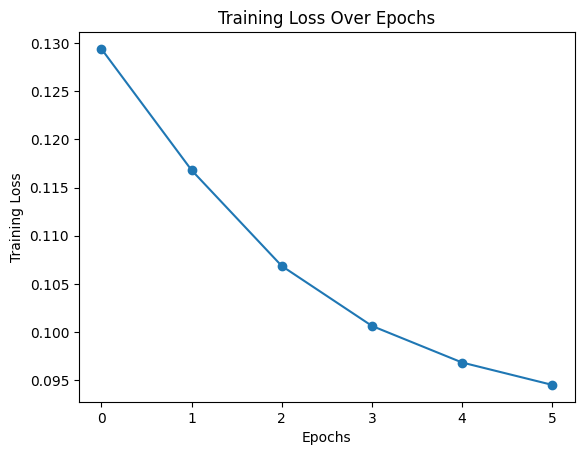

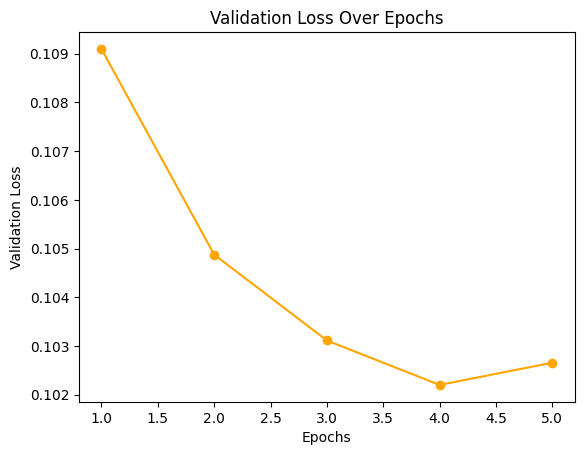

Best multi-task model saved to: ./best_multitask_model
Evaluating EN multi-task test set


Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

EN - Macro-F1 Label1: 0.7192, Label3: 0.6666, Average: 0.6929


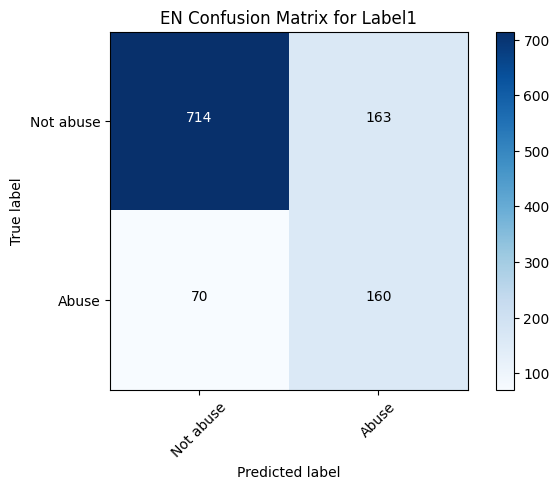

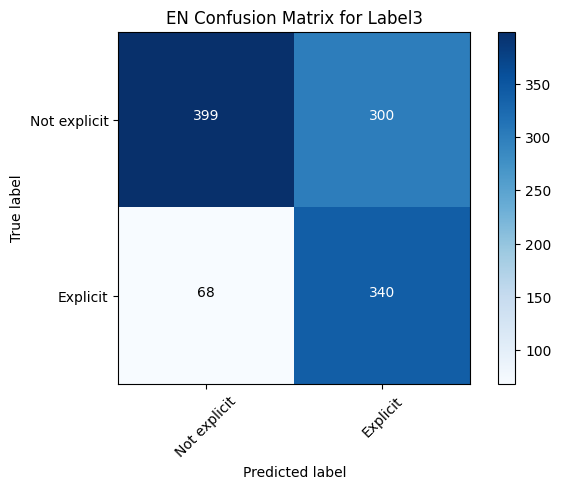

Evaluating HI multi-task test set


/tmp/ipykernel_19/687636930.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(convert_hinglish_to_hindi)
/tmp/ipykernel_19/1963718655.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[annotator_cols] = df[annotator_cols].apply(pd.to_numeric, errors='coerce')
/tmp/ipykernel_19/1963718655.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Map:   0%|          | 0/1516 [00:00<?, ? examples/s]

HI - Macro-F1 Label1: 0.6065, Label3: 0.6900, Average: 0.6482


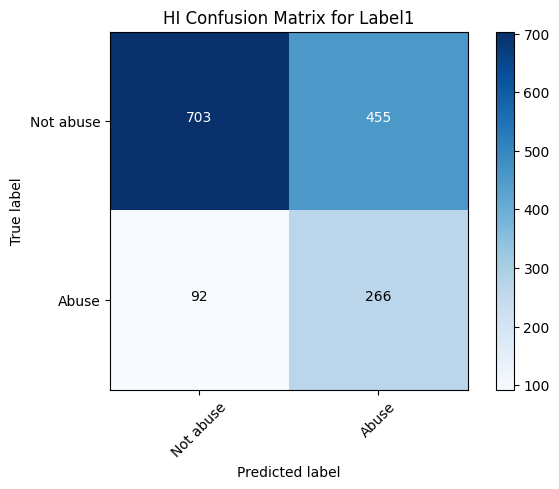

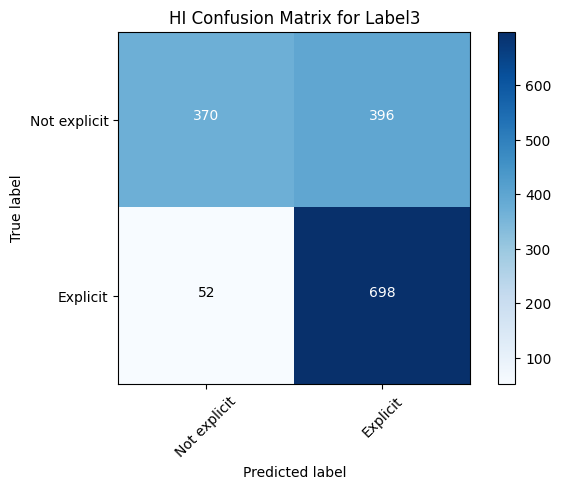

Evaluating TA multi-task test set


Map:   0%|          | 0/1135 [00:00<?, ? examples/s]

TA - Macro-F1 Label1: 0.7769, Label3: 0.8619, Average: 0.8194


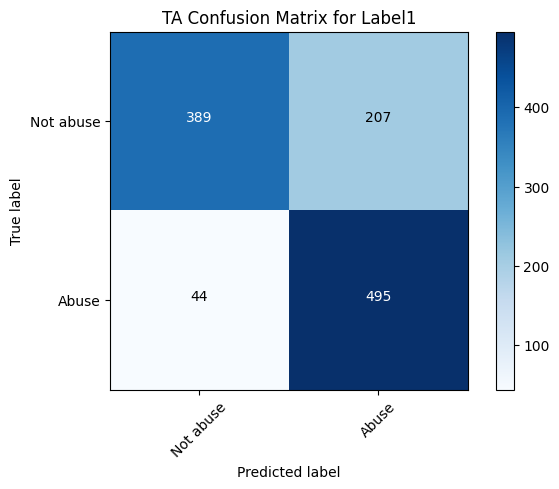

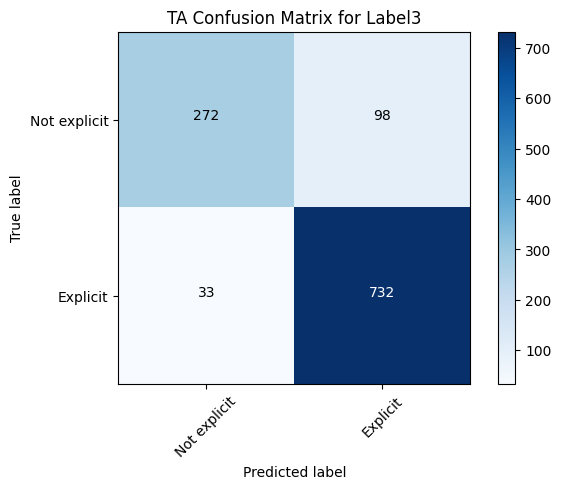

Multi-task evaluation on test sets complete.


In [8]:

def infer_sentence_multitask(sentence, model, tokenizer):
    def prepare_inputs():
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
        return {k: v.to(device) for k, v in inputs.items()}, device

    def get_predictions(inputs):
        
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
        logits1 = outputs["logits1"].detach().cpu().numpy()
        logits3 = outputs["logits3"].detach().cpu().numpy()
        pred1 = np.argmax(logits1, axis=-1)[0]
        pred3 = np.argmax(logits3, axis=-1)[0]
        return ("Gendered abuse" if pred1 == 1 else "Not gendered abuse",
                "Explicit language" if pred3 == 1 else "Not explicit")

    inputs, _ = prepare_inputs()
    return get_predictions(inputs)



def main():
    def run_training_mode():
        
        print("=== Training Mode for Multi-Task ===")
        trainer_mt = train_multitask_model()
        evaluate_multitask_test_sets(trainer_mt)

    def run_inference_mode():
        
        print("=== Inference Mode for Multi-Task ===")
        config = BertConfig.from_pretrained(MODEL_NAME)
        loaded_model = MultiTaskBert.from_pretrained(BEST_MODEL_DIR, config=config)
        temp_trainer = Trainer(model=loaded_model)
        evaluate_multitask_test_sets(temp_trainer)
        example_text = "You should be ashamed of yourself!"
        pred1, pred3 = infer_sentence_multitask(example_text, loaded_model, tokenizer)
        print("\nSingle-Sentence Inference Example:")
        print("Text:", example_text)
        print("Prediction for Gendered abuse:", pred1)
        print("Prediction for Explicit language:", pred3)

    if mode_flag == "train":
        run_training_mode()
    elif mode_flag == "infer":
        run_inference_mode()
    else:
        print("Invalid mode_flag. Please set it to 'train' or 'infer'.")

if __name__ == "__main__":
    main()


In [10]:
import shutil
from IPython.display import FileLink

# Paths and filenames
folder_to_zip = "/kaggle/working/best_multitask_model"
output_filename = "best_multitask_model_zip"

# Create a ZIP archive of the folder
shutil.make_archive(output_filename, 'zip', folder_to_zip)

# Display a download link
print("Zipped folder saved as: " + output_filename + ".zip")
FileLink(f"{output_filename}.zip")

Zipped folder saved as: best_multitask_model_zip.zip


/kaggle/working/best_multitask_model_zip.zip